### SVM代码实现

In [1]:
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

In [3]:
dataMat,labelMat=loadDataSet("data/svm1.txt")

In [4]:
dataMat

[[3.542485, 1.977398],
 [3.018896, 2.556416],
 [7.55151, -1.58003],
 [2.114999, -0.004466],
 [8.127113, 1.274372],
 [7.108772, -0.986906],
 [8.610639, 2.046708],
 [2.326297, 0.265213],
 [3.634009, 1.730537],
 [0.341367, -0.894998],
 [3.125951, 0.293251],
 [2.123252, -0.783563],
 [0.887835, -2.797792],
 [7.139979, -2.329896],
 [1.696414, -1.212496],
 [8.117032, 0.623493],
 [8.497162, -0.266649],
 [4.658191, 3.507396],
 [8.197181, 1.545132],
 [1.208047, 0.2131],
 [1.928486, -0.32187],
 [2.175808, -0.014527],
 [7.886608, 0.461755],
 [3.223038, -0.552392],
 [3.628502, 2.190585],
 [7.40786, -0.121961],
 [7.286357, 0.251077],
 [2.301095, -0.533988],
 [-0.232542, -0.54769],
 [3.457096, -0.082216],
 [3.023938, -0.057392],
 [8.015003, 0.885325],
 [8.991748, 0.923154],
 [7.916831, -1.781735],
 [7.616862, -0.217958],
 [2.450939, 0.744967],
 [7.270337, -2.507834],
 [1.749721, -0.961902],
 [1.803111, -0.176349],
 [8.804461, 3.044301],
 [1.231257, -0.568573],
 [2.074915, 1.41055],
 [-0.743036, -1.73

### 画散点图

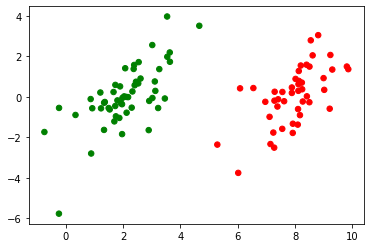

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

### alpha的选取，随机选择一个不等于i值的j

In [6]:
def selectJrand(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

### 进行剪辑

<img src="images/01.png" align="left" width="300" />

In [7]:
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

### SMO算法的核心实现
<img src="images/02.png" align="left" width="250" />
<img src="images/03.png" align="left" width="250" />
<img src="images/04.png" align="left" width="250" />

In [8]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).transpose()
    #初始化b为0
    b = 0; 
    #获取数据维度
    m,n = shape(dataMatrix)
    #初始化所有alpha为0
    alphas = mat(zeros((m,1)))
    iter = 0
    #迭代求解
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            #计算g(xi)
            gXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            #计算Ei
            Ei = gXi - float(labelMat[i])
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                #随机选择一个待优化的alpha（先随机出alpha下标）
                j = selectJrand(i,m)
                #计算g(xj)
                gXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                #计算Ej
                Ej = gXj - float(labelMat[j])
                #把原来的alpha值复制，作为old值
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                #计算上下界
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: print("L==H"); continue
                #计算eta
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue
                #计算alpha[j]，为了和公式对应把j看出2
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                #剪辑alpha[j]，为了和公式对应把j看出2
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); continue
                #计算alpha[i] ，为了和公式对应把j看出1
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                #计算b1
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                #计算b2
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                #求解b
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        print("iteration number: %d" % iter)
    return b,alphas

### 计算w
<img src="images/05.png" align="left" width="250" />

In [9]:
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    #初始化w都为1
    w = zeros((n,1))
    #循环计算
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

### 调用上述方法，求解w，b，alpha

In [10]:
b,alphas = smoSimple(dataMat,labelMat,0.6,0.001,40)
w = calcWs(alphas,dataMat,labelMat)
print('b=',b)
print('alphas=',alphas)
print('w=',w)

L==H
L==H
L==H
L==H
iter: 0 i:4, pairs changed 1
j not moving enough
iter: 0 i:8, pairs changed 2
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
iter: 0 i:4, pairs changed 1
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
iteration number: 0
iter: 0 i:8, pairs changed 1
iter: 0 i:17, pairs changed 2
L==H
L==H
L==H
iter: 0 i:55, pairs changed 3
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iter: 2 i:23, pairs changed 1
j not moving enough
L==H
j not mov

j not moving enough
iter: 1 i:29, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough


iteration number: 5
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 11
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 12
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 13
L==H
j

j not moving enough
iteration number: 0
iter: 0 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
iter: 7 i:54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
iteration number: 3
j not moving enough


iteration number: 14
j not moving enough
j not moving enough
iteration number: 15
j not moving enough
j not moving enough
iteration number: 16
j not moving enough
j not moving enough
iteration number: 17
j not moving enough
j not moving enough
iteration number: 18
j not moving enough
j not moving enough
iteration number: 19
j not moving enough
j not moving enough
iteration number: 20
j not moving enough
j not moving enough
iteration number: 21
iter: 21 i:17, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
i

### 画决策平面

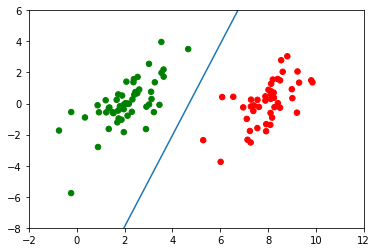

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

x = arange(-2.0, 12.0, 0.1)
y = (-w[0]*x - b)/w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])
plt.show()

### 画支持向量

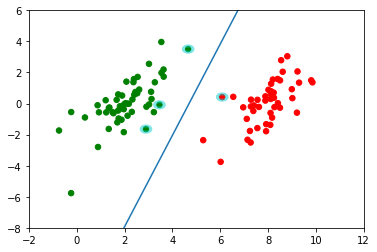

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

x = arange(-2.0, 12.0, 0.1)
y = (-w[0]*x - b)/w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])


alphas_non_zeros_index = where(alphas>0)
for i in alphas_non_zeros_index[0]:
    circle = Circle((dataMat[i][0], dataMat[i][1]), 0.2, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
plt.show()